In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("UBER.csv", index_col="Date", parse_dates=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500


In [3]:
data2 = data.copy()
data2['High-Open'] = data2['High']-data2['Open']
data2['Open-Low'] = data2['Open']-data2['Low']
data2['Open-Close'] = data2['Open']-data2['Close']
data2 = data2.drop(['Close', 'High', 'Low','Adj Close'],axis=1)
data2.head()

,Open,Volume,High-Open,Open-Low,Open-Close
Date,,,,,
2019-05-10,42.000000,186322500,3.000000,0.939999,0.430000
2019-05-13,38.790001,79442400,0.450001,2.709999,1.690003
2019-05-14,38.310001,46661100,1.649998,1.460003,-1.649998
2019-05-15,39.369999,36086100,2.510002,0.419998,-1.920002
2019-05-16,41.480000,38115500,2.580001,0.230000,-1.520000


In [4]:
corr = data2.corr()
corr.style.background_gradient(cmap='coolwarm')

,Open,Volume,High-Open,Open-Low,Open-Close
Open,1.000000,-0.212582,0.073984,0.231944,0.109154
Volume,-0.212582,1.000000,0.361729,0.154924,-0.094651
High-Open,0.073984,0.361729,1.000000,-0.356857,-0.744248
Open-Low,0.231944,0.154924,-0.356857,1.000000,0.719041
Open-Close,0.109154,-0.094651,-0.744248,0.719041,1.000000


In [5]:
vol = data['Volume']
vol.head()

Date
2019-05-10    186322500
2019-05-13     79442400
2019-05-14     46661100
2019-05-15     36086100
2019-05-16     38115500
Name: Volume, dtype: int64

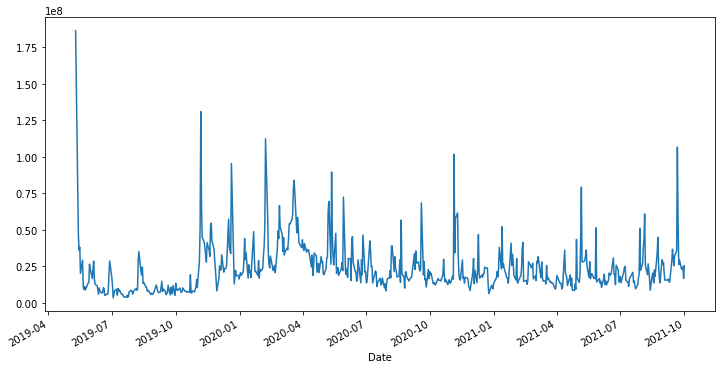

In [6]:
vol.plot(figsize=(12,6))

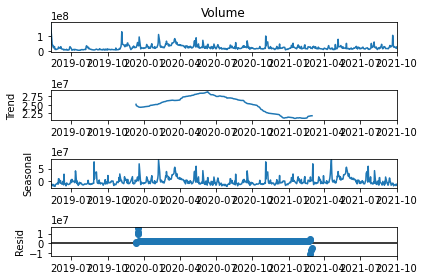

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(data['Volume'],period=300)
results.plot();

In [45]:
train = data[['Volume']].iloc[:590]
test = data[['Volume']].iloc[590:]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# scaled_train = scaled[:540]
# scaled_test = scaled_[540:]
scaled_train.shape, scaled_test.shape

((590, 1), (15, 1))

In [46]:
scaled_train[:10]

array([[1.        ],
       [0.41577217],
       [0.23658308],
       [0.17877803],
       [0.18987113],
       [0.09208194],
       [0.14125914],
       [0.04057504],
       [0.03120926],
       [0.04230783]])

In [47]:
from keras.preprocessing.sequence import TimeseriesGenerator as TG

In [48]:
n_input = 12
n_features = 1
generator = TG(scaled_train, scaled_train, length=n_input, batch_size=1)

In [49]:
# given the data of 12 days, predict volume of third day
X,y = generator[0]
print("Given this",X.flatten())
print("predict this",y)

Given this [1.         0.41577217 0.23658308 0.17877803 0.18987113 0.09208194
 0.14125914 0.04057504 0.03120926 0.04230783 0.02955464 0.05472539]
predict this [[0.05838119]]


In [50]:
X.shape

(1, 12, 1)

In [51]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [52]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.fit(generator, epochs=50)

Epoch 1/50
578/578 [==============================] - 4s 7ms/step - loss: 0.0055
Epoch 2/50
578/578 [==============================] - 3s 6ms/step - loss: 0.0050
Epoch 3/50
578/578 [==============================] - 3s 6ms/step - loss: 0.0048
Epoch 4/50
578/578 [==============================] - 3s 6ms/step - loss: 0.0046
Epoch 5/50
578/578 [==============================] - 3s 6ms/step - loss: 0.0045
Epoch 6/50
578/578 [==============================] - 4s 7ms/step - loss: 0.0045
Epoch 7/50
578/578 [==============================] - 4s 6ms/step - loss: 0.0045
Epoch 8/50
578/578 [==============================] - 3s 6ms/step - loss: 0.0045
Epoch 9/50
578/578 [==============================] - 3s 6ms/step - loss: 0.0044
Epoch 10/50
578/578 [==============================] - 4s 6ms/step - loss: 0.0043
Epoch 11/50
578/578 [==============================] - 3s 6ms/step - loss: 0.0044
Epoch 12/50
578/578 [==============================] - 3s 6ms/step - loss: 0.0044
Epoch 13/50
578/578 [====

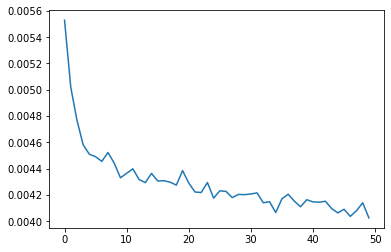

In [55]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [56]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

array([[0.07585793]], dtype=float32)

In [57]:
scaled_test[0]

array([0.13932684])

In [58]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1, n_input, n_features)

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [59]:
test_predictions

[array([0.07585793], dtype=float32),
 array([0.08605263], dtype=float32),
 array([0.09927825], dtype=float32),
 array([0.11598846], dtype=float32),
 array([0.13373712], dtype=float32),
 array([0.15082105], dtype=float32),
 array([0.16480735], dtype=float32),
 array([0.17522076], dtype=float32),
 array([0.18151939], dtype=float32),
 array([0.1843752], dtype=float32),
 array([0.18575627], dtype=float32),
 array([0.18579416], dtype=float32),
 array([0.18543062], dtype=float32),
 array([0.1856899], dtype=float32),
 array([0.1877417], dtype=float32)]

In [60]:
test.head()

,Volume
Date,
2021-09-13,28868800
2021-09-14,36717300
2021-09-15,30368800
2021-09-16,25374000
2021-09-17,32165000


In [61]:
true_predictions = scaler.inverse_transform(test_predictions)

In [62]:
test['Predictions'] = true_predictions

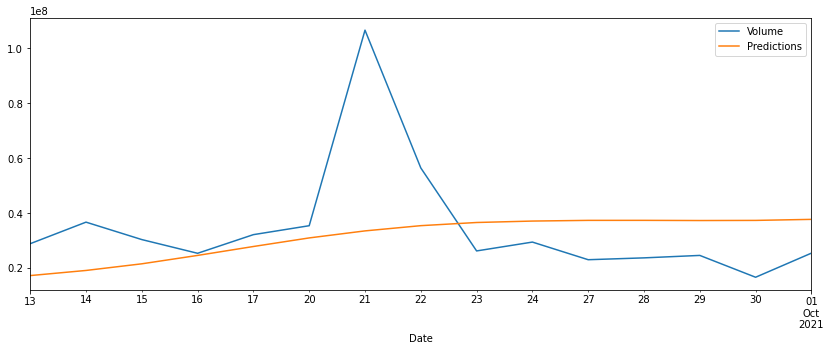

In [64]:
test.plot(figsize = (14,5))

In [65]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
rmse = sqrt(mse(test['Volume'],test['Predictions']))
print(rmse)

22576943.532087244
